In [112]:
import numpy as np
from time import time, sleep

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from random import shuffle
import random


from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


import math 

from tqdm import tqdm

Global Variables & GPU/CPU handling

In [119]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

batch_size = 512
epochs = 10000
learning_rate = 1.75e-3

bottleneck_size = 64
net_size = 324

use_cuda = torch.cuda.is_available()
dtype = 'float32' if use_cuda else 'float64'
torchtype = {'float32': torch.float32, 'float64': torch.float64}

## Autoencoder Class
10 layers total
- 784 (original flattened 28x28)  -> 324
- 324 -> 256
- 256 -> 121
- 121 -> 81
- 81 -> 64
- 64 -> 81
- 81 -> 121
- 121 -> 256
- 256 -> 324
- 324 -> 784

In [134]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        

        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=net_size
        )
        self.encoder_output_layer = nn.Linear(
            in_features=net_size, out_features=256
        )
        self.extra_one_layer = nn.Linear(
            in_features=256, out_features=121
        )
        #"""
        self.extra_bufferone_layer = nn.Linear(
            in_features=121, out_features=81
        )
        #"""
        self.extra_two_layer = nn.Linear( #This is latent representation 8x8
            in_features=81, out_features=bottleneck_size
        )
        self.extra_three_layer = nn.Linear(
            in_features=bottleneck_size, out_features=81
        )
        #"""
        self.extra_buffertwo_layer = nn.Linear(
            in_features=81, out_features=121
        )
        #"""
        self.extra_four_layer = nn.Linear(
            in_features=121, out_features=256
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=256, out_features=net_size
        )
        self.decoder_output_layer = nn.Linear(
            in_features=net_size, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)

        activation = self.encoder_output_layer(activation)
        activation = torch.relu(activation)


        activation = self.extra_one_layer(activation)
        activation = torch.relu(activation)

        #"""
        activation = self.extra_bufferone_layer(activation)
        activation = torch.relu(activation)
        #"""

        code1 = self.extra_two_layer(activation)
        activation = torch.relu(code1)

        activation = self.extra_three_layer(activation)
        activation = torch.relu(activation)

        #"""
        activation = self.extra_buffertwo_layer(activation)
        activation = torch.relu(activation)
        #"""

        activation = self.extra_four_layer(activation)
        activation = torch.relu(activation)

        activation = self.decoder_hidden_layer(activation)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)

        return reconstructed, code1

def bench_k_means(estimator, name, data):
    #t0 = time()
    estimator.fit(data)
    """
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))
                                      """

## Run snippet below to train network

data = data[1:x] 

change x to get a larger set


In [135]:
start = time()
data = np.load("training_data.npy",allow_pickle=True)
shuffle(data)#shuffles data (very fast)
end = time()
# data[0] = image and labels
# data[0][0] = image
# data[0][1] = one hot array with labels
# data[0][0][0] = one line of image
data = data[1:1000]

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

#train_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)
training_dataset = []
for i in range(int(len(data)-(len(data)/5))): #80% of data is training
    training_dataset.append(data[i][0])
train_dataset = torch.Tensor(list(training_dataset))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()


pbar = tqdm(range(epochs))
for epoch in pbar:
    loss = 0
    for batch_features in train_loader: #Used to have ,_ in front of batch_features
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs, _ = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features).to(device)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = (loss / len(train_loader))

    # display the epoch training loss
    pbar.set_postfix({'recon loss': "{:.8f}".format(loss)})
    #print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

#test_dataset = torchvision.datasets.MNIST(
 #   root="~/torch_datasets", train=False, transform=transform, download=True
#)

100%|█████████████████████| 10000/10000 [02:12<00:00, 75.47it/s, recon loss=248.68477631]


## Test the model

In [136]:
test_dataset = []
#print(int((len(data)/5)*4))
#print(len(data))
for i in range(int((len(data)/5)*4),len(data)): #last 20% of data is test
    #for j in range(len(data[i][0])):
    test_dataset.append(data[i][0])
test_dataset = torch.Tensor(list(test_dataset))
#print(len(test_dataset))
test_loader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False
)


test_example = None
test_examples = []
reconstruction_examples = []
k_representations = []

with torch.no_grad():
    for batch_features in test_loader:
        batch_feature = batch_features[0]
        test_example = batch_feature.view(-1, 784).to(device)
        reconstruction, representation = model(test_example)
        test_examples.append(batch_features[0])
        reconstruction_examples.append(reconstruction.cpu().numpy().reshape(28,28))
        k_representations.append(representation.cpu().numpy().reshape(int(math.sqrt(bottleneck_size)),int(math.sqrt(bottleneck_size))))



## Run below to get samples of your test

In [1]:
"""
GET 3 RANDOM SETS OF ORIGINAL / LATENT / RECONSTRUCTION
Pulls from test set
"""
with torch.no_grad():
    
    #number of images to display at once
    #3 fits nicely on my jupyter notebook
    number = 3
    
    #initialize randomness in pulling images
    random.seed(a=None, version=2)
    i_offset = random.randint(0, len(test_examples)-number)
    
    #formatting
    plt.figure(figsize=(21, 21))
    plt.subplots_adjust(wspace=0.0,hspace=0.0)
    plt.tight_layout()
    
    for index in range(number):
        # display original
        ax = plt.subplot(3, number,index+1)
        plt.imshow(test_examples[index+i_offset].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display hidden layer?
        ax = plt.subplot(3, number,index + 1*number+1)
        plt.imshow(k_representations[index+i_offset])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index +  2*number+1 )
        plt.imshow(reconstruction_examples[index+i_offset])
        plt.gray()
        
        #display loss under each picture
        ax.set_xlabel("Loss:"+str(criterion(torch.from_numpy(reconstruction_examples[index]),torch.from_numpy(test_examples[index].numpy().reshape(28,28))).item()),fontsize=18)
        
        #Hide x-axis ticks
        ax.axes.xaxis.set_ticks([])
        
        #ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        #print("Loss:"+str(criterion(torch.from_numpy(reconstruction_examples[index]),torch.from_numpy(test_examples[index].numpy().reshape(28,28))).item()))

    plt.show() # UNCOMMENT TO VIEW AUTOENCODER EXAMPLE

NameError: name 'torch' is not defined

## Kmeans generator

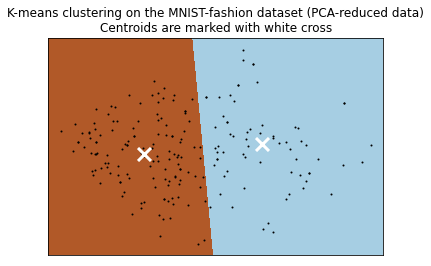

In [139]:
sample_size = 200
n_classes = 2


nsamples, nx, ny = np.array(k_representations, dtype=np.double).shape
d2_k_representations = np.array(k_representations, dtype=np.double).reshape((nsamples,nx*ny))

data = scale(d2_k_representations)
"""
bench_k_means(KMeans(init='k-means++', n_clusters=n_classes, n_init=2),
          name="k-means++", data=data)

pca = PCA(n_components=n_classes).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_classes, n_init=1),
          name="PCA-based",
          data=data)
"""
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_classes, n_init=2)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the MNIST-fashion dataset (PCA-reduced data)\n'
        'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()